In [0]:
## We need plotting from lib
## Copy it in google drive or upload to colab directly
## Gym is already installed on colab
## If not run 
## !pip install gym

# from google.colab import drive
# drive.mount('/content/drive')

# !cp -a drive/My\ Drive/Colab\ Notebooks/RL_Notebooks/lib /content/

In [0]:
import gym
import matplotlib
import numpy as np
import random
import sys
from collections import defaultdict
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.blackjack import draw_hand, sum_hand, score
from lib import plotting

matplotlib.style.use('ggplot')
%matplotlib inline

### Blackjack Environment

[How-to-play-blackjack](https://bicyclecards.com/how-to-play/blackjack/)

Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. They're playing against a fixed dealer.

* Face cards (Jack, Queen, King) have point value 10.
* Aces can either count as 11 or 1, and it's called 'usable' at 11.
* This game is placed with an infinite deck (or with replacement).
* The game starts with each (player and dealer) having one face up and one
face down card.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.

The observation of a 3-tuple of: 

* the players current sum,
* the dealer's one showing card (1-10 where 1 is ace),
* whether or not the player holds a usable ace (0 or 1).


In [0]:
env = BlackjackEnv()

In [5]:
# random seed to draw a hand, it's sum and score
env.seed(seed=42)
hand = draw_hand(env.np_random)
print ("Draw a random hand:", hand) # 2 cards of value
print ("Total of current hand:", sum_hand(hand)) # total value of hands
print ("Score of current hand:", score(hand)) # (busted=0) if sum > 21

Draw a random hand: [10, 10]
Total of current hand: 20
Score of current hand: 20


In [0]:
# actions: stick=0, hit=1
actions = ["stick", "hit"]

In [7]:
# Current observation : players current sum, dealer's card, usable ace
print ("Current observation:", env._get_obs())
print ("Player's card:", env.player)
print ("Dealer's card:", env.dealer)

Current observation: (13, 10, False)
Player's card: [7, 6]
Dealer's card: [10, 5]


In [8]:
# Taking a step by selecting a random action[stick=0, hit=1] from current state
# next_obs: 3-tuple of (player's current sum, dealer's one card, usable ace) 
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?

# Player lost, dealer sum > Player sum
rnd_action = random.randint(0, 1)
print ("Action taken:", actions[rnd_action])
next_obs, reward, is_terminal, _ = env.step(rnd_action)

print ("Player's card:", env.player)
print ("Dealer's card:", env.dealer)
print ("Next observation:", next_obs)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

Action taken: hit
Player's card: [7, 6, 8]
Dealer's card: [10, 5]
Next observation: (21, 10, False)
Reward recieved: 0
Terminal state: False


In [0]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [20]:
# generate a episode in blackjack environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = BlackjackEnv()
    while True:
        curr_state = env._get_obs()
        if verbose:
            print ("Current observation:")
            print ("Player's card:", env.player)
            print ("Dealer's card:", env.dealer[0])
        action = policy(curr_state)
        next_obs, reward, is_terminal, _ = env.step(action)
        if verbose:
            print ("Action taken:", actions[action])
            print ("Player's card:", env.player)
            if action:
                print ("Dealer's card:", env.dealer[0])
            else:
                print ("Dealer's card:", env.dealer)
            print ("Next observation:", next_obs)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            print ("-"*20)
        episode.append((curr_state, action, reward))
        if (is_terminal):
            break
    return episode
e = generate_episode(sample_policy, True)
print ("Episode:", e)

Current observation:
Player's card: [5, 10]
Dealer's card: 1
Action taken: -0.029411764705882353
Player's card: [5, 10, 2]
Dealer's card: 1
Next observation: (17, 1, False)
Reward recieved: 0
Terminal state: False
--------------------
Current observation:
Player's card: [5, 10, 2]
Dealer's card: 1
Action taken: -0.029411764705882353
Player's card: [5, 10, 2, 6]
Dealer's card: 1
Next observation: (23, 1, False)
Reward recieved: -1
Terminal state: True
--------------------
Episode: [((15, 1, False), 1, 0), ((17, 1, False), 1, -1)]


### Monte Carlo Prediction

#### First Visit

 Each occurrence of state $s$ in an episode is called a visit to $s$.

$$ \begin{aligned} V(s_{t}) &= V(s_{t}) + \frac{1}{N(s_{t})}(G_{t} - V(s_{t})),\end{aligned} $$

where $G_{t}$ is total return from time step $t$ and $N(s_{t})$ keeps track of visits to state $s_{t}$.

![first visit](images/mc_first_visit.png)

In [0]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    def state_returns(state, episode):
        rt = 0
        tmp = 0
        for i, e in enumerate(episode):
            if (e[0] == state):
                tmp = i
                break
        # get total return from state
        rt = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[tmp:])])
        return rt

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # The final value function
    V = defaultdict(float)

    for n in range(num_episodes):
        ep = generate_episode(policy, False)

        states_in_episode = set([tuple(e[0]) for e in ep])
        for state in states_in_episode:
            G = state_returns(state, ep)
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state] / returns_count[state]                 

    return V

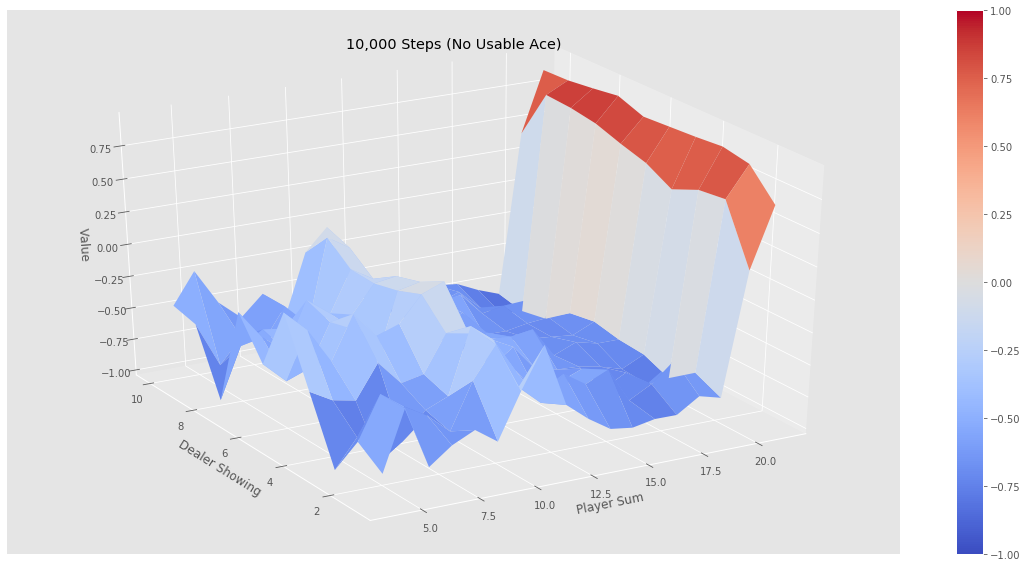

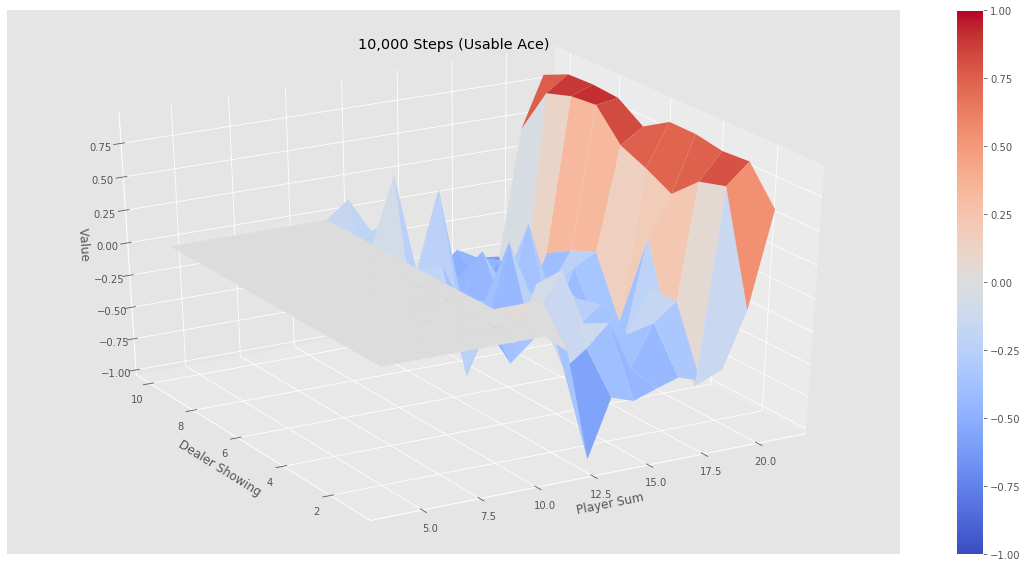

CPU times: user 18.9 s, sys: 2.95 s, total: 21.8 s
Wall time: 21.6 s


In [12]:
%%time
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

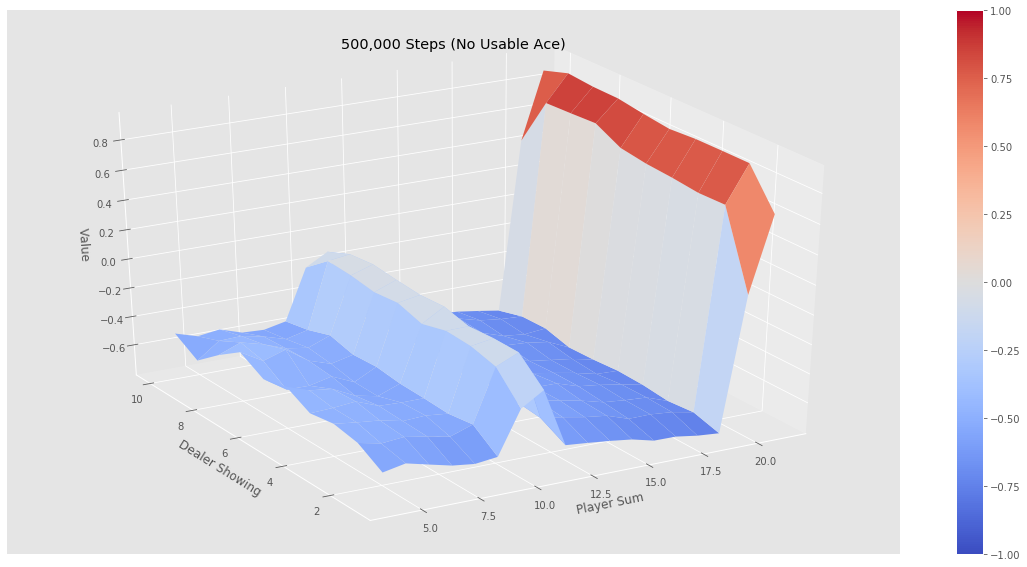

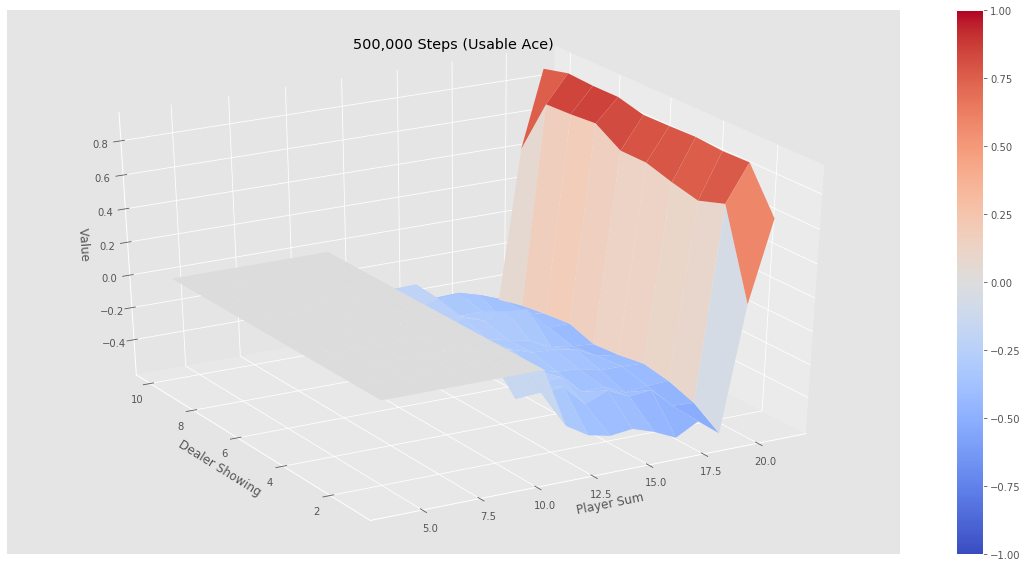

CPU times: user 14min 32s, sys: 9.24 s, total: 14min 41s
Wall time: 14min 41s


In [13]:
%%time
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

### Monte Carlo Control with $\epsilon$-greedy policy (On-policy)

$\epsilon$-greedy policy:

$$ \begin{aligned} \pi(a \vert s) = \begin{cases} \frac{\epsilon}{m} + 1 - \epsilon &\mbox{if } a = argmax_{a \in \mathcal{A}}Q(s, a)\\ \frac{\epsilon}{m} & otherwise \end{cases} \end{aligned} $$

![mc_control](images/mc_control.png)


In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [19]:
# generate a episode in blackjack environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = BlackjackEnv()
    while True:
        curr_state = env._get_obs()
        if verbose:
            print ("Current observation:")
            print ("Player's card:", env.player)
            print ("Dealer's card:", env.dealer[0])
        
        probs = policy(curr_state)
        action = np.random.choice(a=np.arange(len(probs)), p=probs)
        next_obs, reward, is_terminal, _ = env.step(action)
        
        if verbose:
            print ("Action taken:", actions[action])
            print ("Player's card:", env.player)
            if action:
                print ("Dealer's card:", env.dealer[0])
            else:
                print ("Dealer's card:", env.dealer)
            print ("Next observation:", next_obs)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            print ("-"*20)
        episode.append((curr_state, action, reward))
        if (is_terminal):
            break
    return episode
    
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy, True)
print ("Episode:", e)

Current observation:
Player's card: [6, 1]
Dealer's card: 10
Action taken: -0.5275590551181102
Player's card: [6, 1]
Dealer's card: [10, 3, 10]
Next observation: (17, 10, True)
Reward recieved: 1.0
Terminal state: True
--------------------
Episode: [((17, 10, True), 0, 1.0)]


In [0]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # epsilon-greedy policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    def state_action_returns(state, action, episode):
        rt = 0
        tmp = 0
        for i, e in enumerate(episode):
            if (e[0] == state and e[1] == action):
                tmp = i
                break
        # get total return from state
        rt = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[tmp:])])
        return rt

    for n in range(num_episodes):
        ep = generate_episode(policy, False)

        states_action_in_episode = set([(tuple(e[0]), e[1]) for e in ep])

        for state_action in states_action_in_episode:
            state, action = state_action
            G = state_action_returns(state, action, ep)
            returns_sum[state_action] += G
            returns_count[state_action] += 1
            Q[state][action] = returns_sum[state_action] / returns_count[state_action]

    return Q, policy

In [17]:
%%time 
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

CPU times: user 15min 10s, sys: 9.31 s, total: 15min 19s
Wall time: 15min 19s


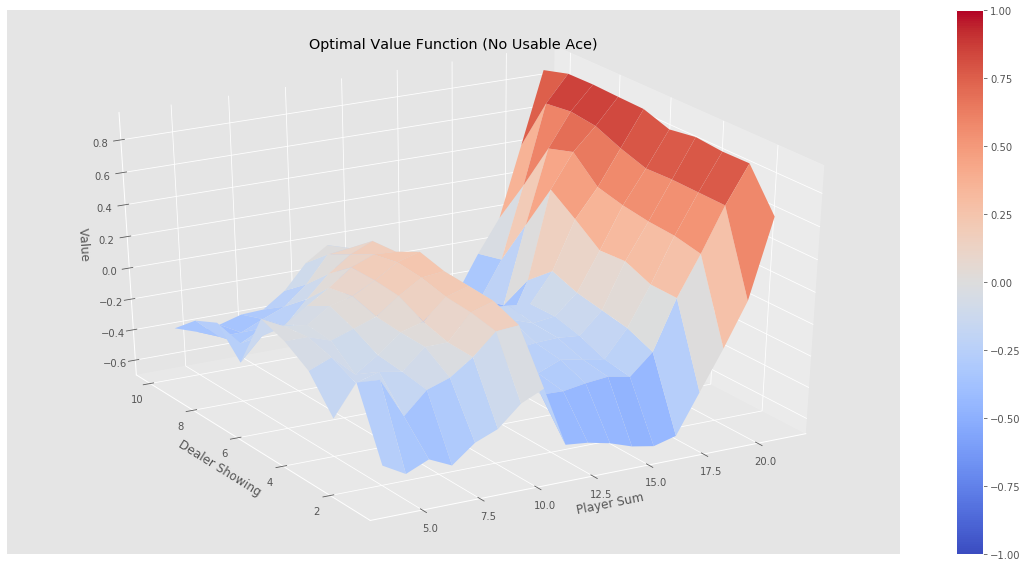

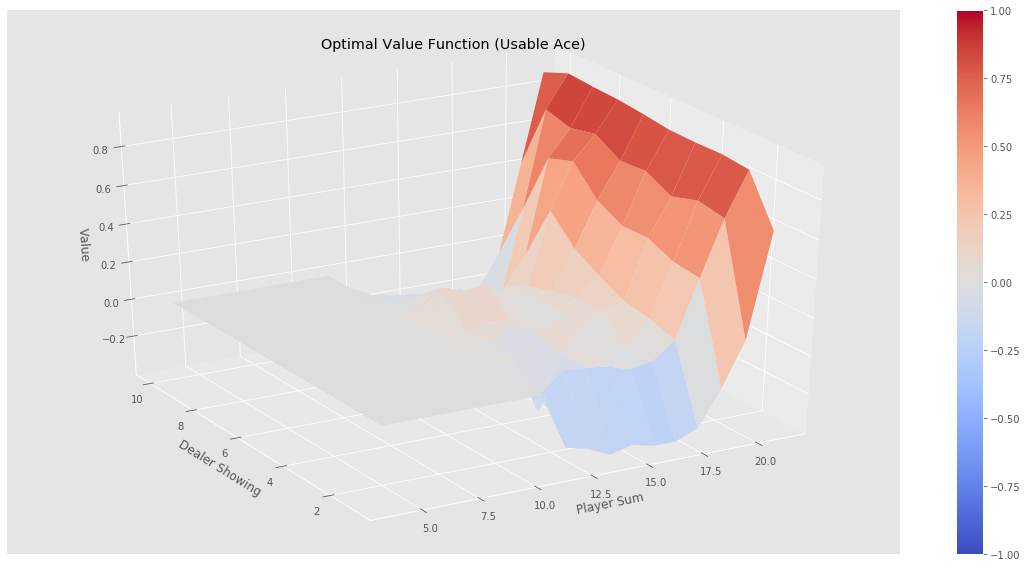

In [18]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)

for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plotting.plot_value_function(V, title="Optimal Value Function")